# **3η Εργαστηριακή Άσκηση στα Νευρωνικά Δικτύα - Deep Learning - Image Captioning**
---
---
---
* Παγώνας Νικόλαος 03118175
* Παπαζαφειρόπουλος Αναστάσιος 03118079
* Γλάρου Μαρία-Ηώς 03118176
---

Τελικό αποτέλεσμα που πετύχαμε: 

```
BLEU score (T = 0) = 0.251 (1001 πρώτες εικόνες του dataset)
BEAM BLEU score = 0.263 (1001 πρώτες εικόνες του dataset και beams = 3)
BEAM BLEU score = 0.264 (1001 πρώτες εικόνες του dataset και beams = 5)
```

Με τις εξής τιμές των hyperparameters:

*   **Embeddings = `glove-wiki-gigaword-300`**
*   **Encoder = `EfficientNetV2S`**
*   **`dropout_rate` = 0.3**
*   **`num_layers` = 3**
*   **`num_heads` = 5**
---

## Download Libraries & Datasets
---

Αρχικά θα κάνουμε mount το drive. Θα δουλέψουμε σε συγκεκριμένο φάκελο όπου βρίσκεται το dataset (το κατεβάζουμε όπως θα δούμε στην συνέχεια την 1η φορά που τρέχουμε το notebook).

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NN/3rd_lab
%ls

# define main_path for downloads and easy access 
MAIN_PATH = '/content/drive/MyDrive/NN/3rd_lab/'

# foldeer with all dataset images
IMAGE_DIR = 'image_dir/'

Mounted at /content/drive
/content/drive/MyDrive/NN/3rd_lab
 captions_new.csv       Lab_350_03_3_3_1.ipynb   Lab_550_05_4_6.ipynb
 image_dir/            'Lab3_final (1).ipynb'    test_files.csv
 Lab_256_04_3_4.ipynb   Lab3_FINAL_450.ipynb     train_files.csv


Κατεβάζουμε τις βιβλιοθήκες που χρειαζόμαστε.

In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.3 MB/s eta 0:00:00


In [3]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 66.3 MB/s eta 0:00:00


Κάνουμε τα κατάλληλα imports.

In [4]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as text
import tensorflow_datasets as tfds

Ελέγχουμε αν έχει ήδη υπάρχει ο φάκελος `IMAGE_DIR = image_dir` στο προσδιορισμένο path και αν η απάντηση είναι αρνητική κατεβάζουμε στον φάκελο αυτό που έχουμε προσδιορίσει το dataset των φωτογραφιών.

In [5]:
if not os.path.exists(MAIN_PATH + IMAGE_DIR):
  image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                        cache_subdir=MAIN_PATH,
                                        origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                        extract=True)
  os.remove(image_zip)

Κατεβάζουμε τα : 
* captions_new.csv, 
* train_files.csv και 
* test_files.csv

In [6]:
# Download captions file

captions_file = tf.keras.utils.get_file('captions_new.csv',

                                           cache_subdir=os.path.abspath('.'),

                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',

                                           extract=False)


# Download train files list

train_files_list = tf.keras.utils.get_file('train_files.csv',

                                           cache_subdir=os.path.abspath('.'),

                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',

                                           extract=False)


# Download test files list

test_files_list = tf.keras.utils.get_file('test_files.csv',

                                           cache_subdir=os.path.abspath('.'),

                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',

                                           extract=False)

Παρακάτω οργανώνουμε τα filenames και τα captions σε μορφή λιστών. Οίζουμε τα paths των captions που θα χρησιμοποιήσουμε στο train και στο test set. Φαίρνουμε τα train και test sets στην κατάλληλη μορφή για το TensorFlow. 

In [7]:
path = pathlib.Path(MAIN_PATH)

# ---------------      

captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

# ---------------   

cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)

# ---------------   

train_files = (path/train_files_list).read_text().splitlines()
test_files = (path/test_files_list).read_text().splitlines()

# ---------------   

train_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in train_files]
test_captions = [(str(path/IMAGE_DIR/fname), cap_dict[fname]) for fname in test_files]

# ---------------   

train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

Για λόγους πληρότητας εκτυπώνουμε κάποια captions (που θα χρησιμοποιηθούν για το training και το testing).

In [8]:
train_captions_df = pd.DataFrame(train_captions)

train_captions_df.columns = ["File","Captions"]
display(train_captions_df.head(3))

File  \
0  /content/drive/MyDrive/NN/3rd_lab/image_dir/_3...   
1  /content/drive/MyDrive/NN/3rd_lab/image_dir/_5...   
2  /content/drive/MyDrive/NN/3rd_lab/image_dir/_6...   

                                            Captions  
0  [The skier is wearing a yellow jumpsuit and sl...  
1  [Two boys are in the foreground of a seashore ...  
2  [A man in jeans and a blue long-sleeved shirt ...

In [9]:
test_captions_df = pd.DataFrame(test_captions)

test_captions_df.columns = ["File","Captions"]
display(test_captions_df.head(3))

File  \
0  /content/drive/MyDrive/NN/3rd_lab/image_dir/_1...   
1  /content/drive/MyDrive/NN/3rd_lab/image_dir/_9...   
2  /content/drive/MyDrive/NN/3rd_lab/image_dir/_8...   

                                            Captions  
0  [a black and white dog wearing a blue shirt ca...  
1  [A man wearing aqua pants and matching flip-fl...  
2  [a large bull targets a man , inches away , in...

In [11]:
print("Train set (files count): ", len(train_files))
print("Test set (files count): ", len(test_files))
print("Dataset (image count): " + str(len(os.listdir(MAIN_PATH + IMAGE_DIR))))

Train set (files count):  21000
Test set (files count):  4524
Dataset (image count): 31784


In [12]:
!ls

 captions_new.csv       Lab_350_03_3_3_1.ipynb	 Lab_550_05_4_6.ipynb
 image_dir	       'Lab3_final (1).ipynb'	 test_files.csv
 Lab_256_04_3_4.ipynb   Lab3_FINAL_450.ipynb	 train_files.csv


Για λόγους πληρότητας εκτυπώνουμε κάποια παραδείγματα.

In [13]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [14]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/NN/3rd_lab/image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


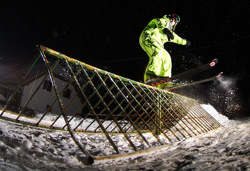

In [15]:
img = Image.open('image_dir/_3430497.jpg')
dims = img.size
sample_img = img.resize((dims[0]//2, dims[1]//2))
sample_img

## Image feature extractor
---

Παρακάτω επιλέγουμε να φορτώσουμε το MobileNetV3Small. Στην επιλογή αυτή οδηγηθήκαμε μετά από δοκιμές διαφορετικών CNNs (Encoders) που συνοψίζονται στον παρακάτω πίνακα, έχοντας θεωρήσει τις εξής τιμές για τις υπόλοιπες υπερπαραμέτρους:
* `vocab_size = 5000`
* `num_layers = 2`
* `num_heads = 2`
* `dropout_rate = 0.5`

CNN  |  Performance (Bleu Score Τ = 0)
-------------------|------------------
Mobilenet          | 0.201
EfficientnetV2S    | 0.171
EfficientnetV2M    | 0.138
EfficientnetV2L    | 0.144 (αρκετά αργό)
EfficientnetB25    | 0.094
Xception           | 0.116
DenseNet           | 0.159



Με βάση τις δοκιμές αυτές καλύτερη επιλογή ως Encoder είναι το MobileNet. 

Είναι αρκετά "ελαφρύ" σε σύγκριση π.χ. με το EfficientnetV2L που συνεπάγεται γρηγορότερο training και υπολογισμό BLEU scores. Παρατηρούμε ότι ενώ το EfficientNet έχει καλύτερο top-1 (85.7% > 70.4%) και top-5 (97.5% > 90.1%) accuracy, καλύτερος extractor από τα παραπάνω αποτελέσματα φαίνεται να είναι το MobileNet. Επειδή και το EfficientnetV2S έχει ικανοποιητικά αποτελέσματα όντας σχετικά "ελαφρύ" θα πειραματιστούμε παρακάτω με τα Mobilenet και EfficientnetV2S. 
Να σημειωθεί ότι δοκιμάστηκαν και τα CNN ConvNeXtLarge και ConvNeXtXLarge τα οποία όμως ήταν πολύ αργά (ειδικά το 2ο) χωρίς να φαίνεται να πετυχαίνουν ιδιαίτερη βελτίωση. 

In [16]:
IMAGE_SHAPE=(224, 224, 3)

# mobilenet
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

# efficientnet
efficientnet = tf.keras.applications.EfficientNetV2S(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
efficientnet.trainable=False

82420632/82420632 [==============================] - 1s 0us/step


H `load_image` είναι μία συνάρτηση που φορτώνει μία εικόνα με είσοδο το path της εικόνας αυτής.

In [17]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

Έχουμε ορίσει τον encoder που θα χρησιμοποιήσουμε οπότε με την βοήθεια της `load_image` φορτώνουμε μία εικόνα-δείγμα και τον τρέχουμε με αυτή. 

In [18]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


### Setup the text tokenizer/vectorizer
---

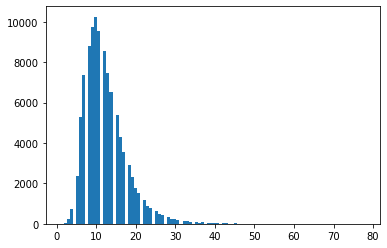

In [19]:
capt_lengths = []
for image in train_captions:
  for caption in image[1]:
    clean_capt = caption.split()[:-1]
    capt_lengths.append(len(clean_capt)) 


plt.figure()
plt.hist(capt_lengths, bins=100)
plt.show()

Το παραπάνω διάγραμμα αποτελεί ένα ιστόγραμμα που απεικονίζει την συχνότητα εμφάνησης των διαφόρων μεγεθών captions. 
Παρατηρούμε ότι τα περισσότερα captions  έχουν μέγεθος μεταξύ 5 και 20. Καθώς η προσπάθεια αφαίρεσης των captions εκτός του ορίου αυτού οδηγεί σε σφάλμα στο fit που δίνεται παρά τα πιθανή βελτίωση που θα περιμέναμε δεν προχωρούμε σε κάτι τέτοιο. 

Ο παρακάτω κώδικας είναι από το tutorial της tensorflow που μας έχει δοθεί. Κατασκευάζει τις αντιστοιχίες μεταξύ αριθμών (indexes) και  λέξεων στο vocabulary που έχουμε. 
Συγκεκριμένα, η `word_to_index` κάνει την μετατροπή από λέξη σε index η `index_to_word` τη μετατροπή από index σε word.

Στο δικό μας notebook έχουμε ορίσει μέσω της `standardize` να γίνονται κάποιες μετατροπές λέξεων, οι οποίες περιγράφονται πλήρως από τα dictionaries `contraction_dict` και `number_dict`. 
Ζητούμενο είναι ο Transformer να μην μπερδεύεται από ορισμένες συντομογραφίες της Αγγλικής γλώσσας (τις πιο συνηθησμένες), κάτι που πετυχαίνουμε με τις αντιστοιχείες που ορίζει το `contraction_dict` και επιπλέον να μην διαφοροποιεί την λεκτική περιγραφή με την αριθμητική περιγραφή των αριθμών (να αντιλαμβάνεται τους αριθμούς ως λέξεις).

In [20]:
import re

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
number_dict = {"1": "one", "2": "two", "3": "three", "4": "four", "5":"five", "6":"six", "7":"seven", "8":"eight", "9":"nine", "0":"zero"}

def standardize(s): 
  s = tf.strings.regex_replace(s, " '", "'")
  for key, val in contraction_dict.items():
    s = tf.strings.regex_replace(s, f"{key}", f"{val}")
  for key, val in number_dict.items():
    s = tf.strings.regex_replace(s, f"{key}", f"{val}")
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

def old_standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s  

Όσον αφορά το μέγεθος του vocabulary θα πειραματιστούμε με τις τιμές 3500, 5000 και 6000. 

Αρχικά πραγματοποιήσαμε τις παρακάτω δοκιμές που μας οδήγησαν στην επιλογή αυτή: 

|Vocab Size|BLEU T=0|Beam Search|
|:-:|:-:|:-:|
|3500|	0.223|		0.230|
|5000|	0.231|	  0.240|
|6000|	0.223|		0.231|
|7000|	0.204|		0.241|

όπου έχουμε θεωρήσεις τις εξής τιμές για τις υπόλοιπες υπερπαραμέτρους που μας ενδιαφέρουν:

* `Embeddings size = 300`
* `CNN = MobileNet`
* `dropout_rate = 0.5`
* `num_heads=2`
* `num_layers=2`

Παρατηρούμε ότι καλύτερα αποτελέσματα έχει το 5000 vocabulary size 

Ορίζουμε το Tokenizer βασισμένο στη παραπάνω επιλογή μας χρησιμοποιώντας τη standardize που ορίσαμε παραπάνω.

In [21]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

Εδώ κάνουμε adapt (σε batches των 1024) το Tokenizer στα captions του train set.

In [22]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Ενδεικτικά, τυπώνουμε τις 10 πρώτες λέξεις του vocabulary του Tokenizer. 

In [23]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

Ενδεικτικά, κάνουμε tokenize και παραθέτουμε το αποτέλεσμα για δύο απλές προτάσεις, "a cat in a hat" και "a robot dog". Παρατηρούμε ότι μετατράπηκαν σε αλληλουχίες αριθμών (indexes των αντίστοιχων λέξεων). Δεδομένου ότι είναι απαραίτητο για την εκπαίδευση του tranformer τα keywords `[START]` και `[END]` να μπαίνουν στην αρχή και στο τέλος κάθε caption, είναι εμφανές ότι ο αριθμός 3 αντιστοιχεί στο keyword `[START]` και ο αριθμός 4 στο keyword `[END]`.

In [24]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 754, 5, 2, 63, 4], [3, 2, 2862, 34, 4]]>

Παρακάτω δημιουργούμε αντιστοιχείες μεταξύ λέξεων και indices.

In [25]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

Για λόγους πληρότητας εκτυπώνουμε και το παραπάνω παράδειμα όπου τα παραπάνω indices τα μετατρέπουμε πίσω σε λέξεις. 

In [26]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [27]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### Prepare the datasets
---

Η συνάρτηση `match_shapes` προέρχεται από το tutorial του tensorflow και αντιστοιχεί τη κάθε εικόνα με το κάθε caption της ξεχωριστά. 

In [28]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

Ενδεικτικά παραθέτουμε ένα παράδειγμα με ένα batch 32 εικόνων, όπου σε κάθε εικόνα αντιστοιχούν 5 captions και για το λόγο αυτό από (32,5) shape καταλήγουμε με 160 = 32*5 shape.

In [29]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


Η συνάρτηση `prepare_txt` (επίσης από το tutorial της εκφώνησης) φέρνει το caption στη κατάλληλη μορφή για το Input του Transformer (πετάει το `[END]` keyword) και για το Output (πετάει το `[START]` keyword).   

In [30]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

Η συνάρτηση `prepare_dataset` προετοιμάζει το dataset (σπάζοντάς το σε batches μεγέθους 32, προχωρόντας σε shuffling, κλπ). 

In [31]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

Εφαρμόζουμε την παραπάνω συνάρτηση για να προετοιμάσουμε το train set. 

In [32]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

Εφαρμόζουμε την παραπάνω συνάρτηση για να προετοιμάσουμε το test set. 

In [33]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

Η συνάρτηση `save_dataset` μας επιτρέπει να κάνουμε cache τα αποτελέσματα του CNN μας ώστε να μην το τρέχουμε κάθε φορά (τόσο στο train όσο και κατά τον υπολογισμό των BLEU scores). Όμως, οι περιορισμοί σε RAM του colab καθηστούν αδύνατη την αξιοποίησή της (έσκαγε το colab από RAM).  

In [34]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [35]:
# save_dataset(train_raw, 'train_cache', mobilenet , tokenizer)
# save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

### Data ready for training
---

In [36]:
# train_ds = load_dataset('train_cache') 
# test_ds = load_dataset('test_cache')

In [37]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

Ενδεικτικά, ακολουθεί ένα παράδειγμα των shapes του Input του Transformer (εικόνα και caption input) καθώς και το shape του expected output. 

In [38]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels)

(32, 224, 224, 3)
(32, 22)
tf.Tensor(
[[   2   52   10   35   12    2   57  396  757    7    2   87   18    6
   917  431    4    0    0    0    0    0]
 [  14   97  134   12    2  215    4    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [  14   88   15  118    7    2  111   81    4    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2    9   42    2  204   12   17   40   79    5    6   86    4    0
     0    0    0    0    0    0    0    0]
 [   2    9   10  323 1871    7    6   39   11    2 4012  104    4    0
     0    0    0    0    0    0    0    0]
 [   2  231  110  262   16 2064    6   66    4    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2  200   35    5   19  252 1787  135    6  284    4    0    0    0
     0    0    0    0    0    0    0    0]
 [   2    9   93  705    7    2  143    4    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [   2    9    8   13 2964    7    2   27 

In [39]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  52  10  35  12   2  57 396 757   7   2  87  18   6 917 431   0
   0   0   0   0]
[  2  52  10  35  12   2  57 396 757   7   2  87  18   6 917 431   4   0
   0   0   0   0]


### Input
---

Παρακάτω δίνεται ο κώδικας που χρησιμοποιούμε όταν θέλουμε να χρησιμοποιήσουμε τα pretrained embeddings, που φορτώνει π.χ. το glove-wiki-gigaword-300.

Κατεβάζουμε τα embeddings και με βάση αυτά για κάθε λέξη του vocabulary το embedding_matrix. 

In [40]:
import gensim.downloader as api

for i in list(api.info()['models'].keys()):
    print(i)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [41]:
embed_model = api.load('glove-wiki-gigaword-300')

[=================================================-] 98.9% 371.8/376.1MB downloaded


In [42]:
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

for idx, word in enumerate(tokenizer.get_vocabulary()):
    try:
        embedding_vector = embed_model[word]
        embedding_matrix[idx] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)
        embedding_matrix[idx] = vec

In [43]:
embedding_matrix.shape

(5000, 300)

Για λόγους πληρότητας συγκρίνουμε τις διαφορετικές διαστάσεις των pretrained Embeddings κάνοντας τις παρακάτω δοκιμές:

|Embeddings|	BLEU Score (T = 0)	|Beam Score|
|:-:|:-:|:-:|
50|	0.056|		0.099|
100|0.178|		0.216|
200	|	0.204|		0.231|
300|	0.208|		0.239|

Παρατηρούμε ότι όσο αυξάνουμε τη διαστατικότητα των Embeddings το BLEU score αυξάνεται. Λογικό καθώς μεγαλύτερες διαστάσεις επιτρέπουν μεγαλύτερες διανυσματικές αποστάσεις μεταξύ διαφορετικών λέξεων και άρα πιο κατατοπιστική περιγραφή των λέξεων. Αυτό έχει κάποιο κατώφλι εμφανώς πέρα από το οποίο μεγαλύτερη διαστατικότητα θα δεν έχει νόημα ή ακόμα και θα έχει αρνητική επίδραση στο BLEU score.

Θα πειραματιστούμε μόνο με το μέγεθος 300 καθώς αποδίδει εμφανώς καλύτερα στο πρόβλημά μας. 

Η `SeqEmbedding` χρησιμοποιείται στο αντίστοιχο layer για να μετατρέψει τα input captions σε  vectors-embeddings.
Παρακάτω σημειώνεται το κομμάτι κώδικα που προστέθηκε για να μπορεί το layer να χρησιμοποιεί τα pretrained embeddings. 




In [44]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()

    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
    
    ##################################################################
    ########### use trainable embeddings #############################
    
    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    ##################################################################
    ########### use pretrained embeddings ############################
    self.token_embedding = tf.keras.layers.Embedding(vocabulary_size,
                                                     EMBEDDING_DIM,
                                                     weights=[embedding_matrix],
                                                     trainable=False)
    ###################################################################
    

    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder
---

Τα παρακάτω κελιά ορίζουν τον Decoder του Transformer.

Παρακάτω ορίζουμε τα layers για το Self Attention και το Cross Attention με τον κώδικα που παρέχεται από το tutorial tensorflow. 

Οι κλάσεις `CausalSelfAttention` και `CrossAttention` παίρνουν ως παράμετρο τον αριθμό των Heads (`num_heads`) με την οποία θα πειραματιστούμε παρακάτω. 

Η βάση και των δύο αυτών layers είναι το **Multihead Attention** που έχει ως Input τα Key, Value, Query και έχει ως Output ένα array.    


In [45]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

In [46]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

Επίσης ορίζεται και το FeedForward layer που αποτελελεί και αυτό μέρος του Transformer.
Η κλάση που ορίζουμε, `FeedForward`,
παίρνει ως παράμετρο το `dropout_rate` με την οποία επίσης θα πειραματιστούμε παρακάτω.

In [47]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Με βάση τα παραπάνω layers, ορίζεται το Decoder Layer.

In [48]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output
---

Παρακάτω ορίζουμε το TokenOuput Layer που παίρνει ως Input τα αποτελέσματα του Decoder και έχει ως Output τα Logits κάθε λέξης (όχι πιθανότητες,  δεν έχει εφαρμοστεί ακόμα `Softmax Layer`). Σημειώνουμε το initialization των biases βασισμένο στη συχνότητα εμφάνησης των λέξεων στα captions του train set προκειμένου να ελαχιστοποιήσει την αρχική εντροπία. 

In [49]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)

    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    return x + self.bias

Παρακάτω κάνουμε adapt το παραπάνω layer στα captions του train set.

In [50]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3282it [48:37,  1.12it/s]


Uniform entropy: 8.52
Marginal entropy: 5.47


### Build the model
---

Ολοκληρώνουμε ορίζοντας τον `Captioner` που συγκεντρώνει-συνίσταται από όλα τα παραπάνω layers. 

In [51]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [52]:
@Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

Μετά από τη λεπτομερή ανάλυση των αποτελέσματων, ορίζουμε το μοντέλο μας με τις παραπάνω υπερπαραμέτρους (βλέπε τέλος notebook).

In [53]:
model = Captioner(tokenizer, feature_extractor=efficientnet, output_layer=output_layer,
                  units=300, dropout_rate=0.3, num_layers=3, num_heads=5)

### Generate captions
---

Παράλληλα κατεβάζουμε την εικόνα με τον surfer για να επιβλέπουμε τη πορεία του Transformer και με τη μορφή caption (και όχι μόνο με το loss). 

In [54]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

64400/64400 [==============================] - 0s 1us/step


Εδώ ορίζεται η συνάρτηση `simple_gen()` του `Captioner` που παράγει το caption της εικόνας εισόδου, δεδομένου της θερμοκρασίας.   

In [55]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

Τυπώνουμε, για λόγους πληρότητας, τα αποτελέσματα του `Captioner` πριν γίνει trained πάνω στην εικόνα του surfer. 

In [56]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a

dressed on water in side the ball team


### Calculate Loss
---

Παρακάτω ορίζουμε τη συνάρτηση `masked_loss` η οποία υπολογίζει (με την `sparse_softmax_cross_entropy_with_logits`.

In [57]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks
---

Ορίζουμε τα κατάλληλα callbacks. Εδώ προσθέτουμε το EarlyStopping ώστε να αποφευχθούν φαινόμενα overfitting.

In [58]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [59]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a
a a a a a a a in a a a
a some are on a fall jumping



In [60]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=10, restore_best_weights=True)]

### Train
---

Τώρα είμαστε έτοιμοι να εκπαιδεύσουμε τον `Captioner`.

In [61]:
efficientnet = tf.keras.applications.EfficientNetV2S(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
efficientnet.trainable=False

In [62]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.0180 - masked_acc: 0.2160

a man in a man in a man in a white shirt is
a man in a man in a
a toy on face waiting on the with a show

100/100 [==============================] - 207s 2s/step - loss: 5.0180 - masked_acc: 0.2160 - val_loss: 4.7046 - val_masked_acc: 0.2444
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.6270 - masked_acc: 0.2632

a man in a white shirt is in a white shirt is in a white shirt is is in a white shirt is in a white shirt is is is is is in a white shirt is in a white shirt is is is in a white shirt is
a man in a a red shirt is standing in a blue shirt is sitting in a white shirt
a steps a his clean mask sleepy electric on kid is in the couple

100/100 [==============================] - 172s 2s/step - loss: 4.6270 - masked_acc: 0.2632 - val_loss: 4.4610 - val_masked_acc: 0.2741
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.4509 - masked_acc

Παρακάτω αποτυπώνουμε διαγραμματικά το loss και το accuracy του μοντέλου μας κατά τη διάρκεια της εκπαίδευσης.

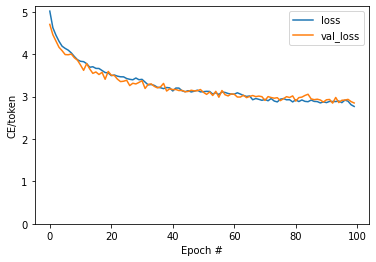

In [63]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

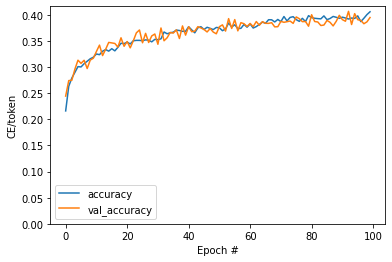

In [64]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

### Attention plots
---

Για λόγους πληρότητας, αποτυπώνουμε διαγραμματικά τα Attention Plots του μοντέλου μας για τη φωτογραφία του surfer.

In [65]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a red wetsuit is surfing'

In [66]:
str_tokens = result.split()
str_tokens.append('[END]')

In [67]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 5, 9, 49]),
 TensorShape([1, 5, 9, 49]),
 TensorShape([1, 5, 9, 49])]

In [68]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [69]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([1.        , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ], dtype=float32)>

In [70]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

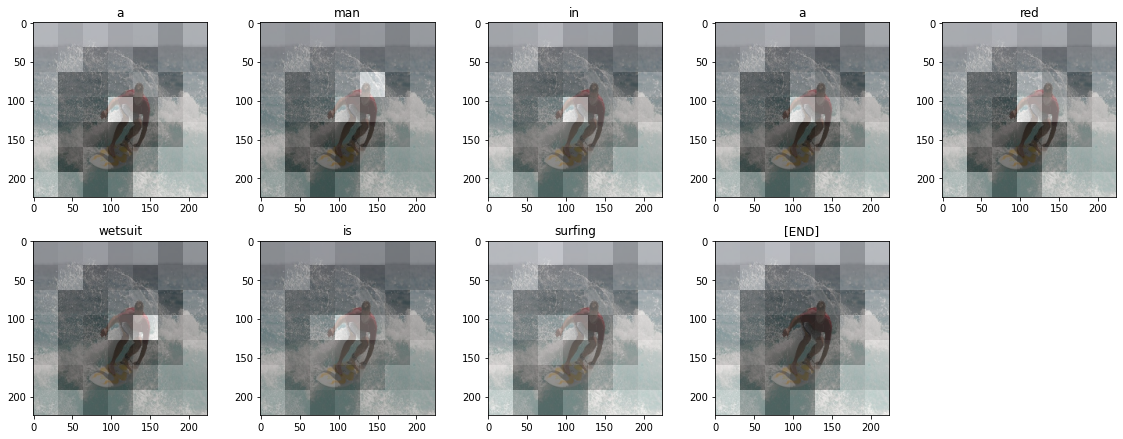

In [71]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [72]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

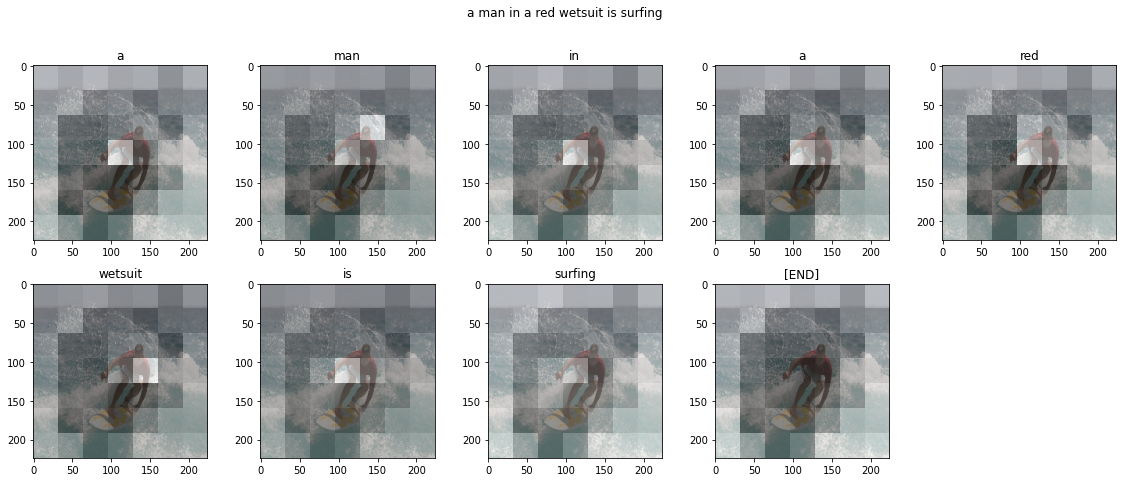

In [73]:
run_and_show_attention(model, image)

### Bleu Scores
---

Eπιλέξαμε να χρησιμοποιήσουμε 1001 εικόνες για τον υπολογισμό του BLEU Score ώστε να είναι αποδεκτοί οι χρόνοι εκτέλεσης. 

Παρακάτω παρατίθεται η συνάρτηση `cal_bleu_sentence` που με είσοδο μία εικόνα υπολογίζει το BLEU score του caption που παρήγαγε το μοντέλο για την εικόνα αυτή δεδομένου της θερμοκρασίας.

Ενδεικτικά, την εφαρμόζουμε σε μία εικόνα για να ελέγξουμε την λειτουργία της. 

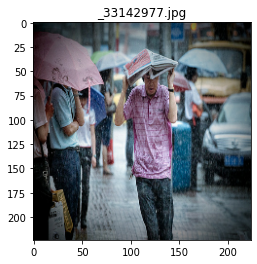

References are:
A man wearing a pink shirt with black stripes is protecting himself from the rain using a newspaper .
People on a sidewalk are trying to protect themselves from the rain with umbrellas and a newspaper .
A man is walking down the street , on a rainy day , holding a newspaper over his head .
A man in a pink shirt running through the rain with a newspaper to cover his head .
A man using a newspaper to keep the rain off of himself .
Hypothesis is: a woman is walking down the street with a red umbrella
BLEU score = 0.455


0.45519218370127795

In [74]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu

def cap_tokenizer(caption):
  caption.lower()
  tokens = caption.split(" ")[:-1]
  return tokens


def cal_bleu_sentence(image_file, model , temp):
   image = load_image(MAIN_PATH + IMAGE_DIR + "/" + image_file)
   plt.figure()
   plt.imshow(image/255)
   plt.title(image_file)
   plt.show()
   hypothesis = model.simple_gen(image,temp)
   hyp_tokens = cap_tokenizer(hypothesis)
   
   tokens_list = []

   print("References are:")
   
   for cap in cap_dict[image_file]:
     tokens_list.append(cap_tokenizer(cap))
     print(cap)
     

   bleu_score = sentence_bleu(tokens_list,hyp_tokens,weights=(0.4, 0.3, 0.2, 0.1),smoothing_function=SmoothingFunction().method1)

   print("Hypothesis is:", hypothesis)

   print(f'BLEU score = {round(bleu_score,3)}')

   return bleu_score


cal_bleu_sentence("_33142977.jpg", model, 0)

Παρακάτω ορίζουμε τη συνάρτηση `simple_gen_beam` η οποία προσπαθεί να επιλέξει για μία εικόνα εισόδου τον κατάλληλο caption χρησιμοποιώντας τον αλγόριθμο Beam Search, όπως αυτός περιγράφεται στο [δοσμένο tutorial](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24).

Αξίζει να αναφερθεό ότι το output από το `Captioner` δεν είναι πιθανότητες, αλλά logits οπότε είναι απαραίτητη η εφαρμογή softmax στο output. 

Επίσης, για να "τιμωρήσουμε" τα πολύ μεγάλα captions που παράγει το μοντέλο μας (συνήθως δεν έχουν και νοηματική συνοχή) προσθέσαμε ένα penalty (ο όρος: *- seq[2]/50*, που σημειώνεται στο κώδικα παρακάτω) που ενθαρρύνει την επιλογή των μικρότερων captions. Τα αποτελέσματα ήταν πολύ ικανοποιητικά μετά τη προσθήκη του penalty, σε σχέση με το να  κανονικοποιούμετα υποψήφια captions διαιρώντας με το μέγεθος τους.


In [75]:
@Captioner.add_method
def simple_gen_beam(self, image, beams = 3):

  
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  end_token = self.word_to_index([['[END]']])
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  captions_queue = [[initial, 0.0, 0]] # (batch, sequence)
  finished = []
  
  
  for n in range(50):
    result = []
    if captions_queue == []:
      break

    for i, seq in enumerate(captions_queue):
      preds = self((img_features, seq[0])).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1, :] #(batch, vocab)
      preds = preds[0, :]
      layer = tf.keras.layers.Softmax()  # APLLY SOFTMAX TO LOGITS !! 
      preds = layer(preds).numpy()
    
      next = tf.argsort(preds, axis=-1).numpy()[-beams:]

      for j in range(len(next)):
        result.append((seq[1]+ np.log(preds[next[j]]), next[j], i))

    last_beams = sorted(result, key=lambda x: x[0], reverse=True)[:beams]

    temp = []
    for prob, logit, index in last_beams:
      logit_ = tf.constant([logit])
      token = tf.concat([captions_queue[index][0], [logit_]], axis=1)
      if logit == end_token:
        finished.append((token.numpy(), captions_queue[index][1]/captions_queue[index][2] - captions_queue[index][2]/50, captions_queue[index][2]))  # <- PENALTY for larger captions (they usually do not make sense)
        continue
      
      new_prob = prob # prob < 1 -> log(prob) < 0
      temp.append([token, new_prob, captions_queue[index][2] + 1])

    captions_queue = temp

  if len(finished) == 0:
    for seq in captions_queue:
      finished.append((seq[0], seq[1]/seq[2] - seq[2]/50, seq[2]))

  return sorted(finished, key=lambda x: x[1], reverse=True)[0]

Ενδεικτικά, τρέχουμε τη `simple_gen_beam` σε μία εικόνα-δείγμα του dataset μας.

a man in a red shirt is walking down the street


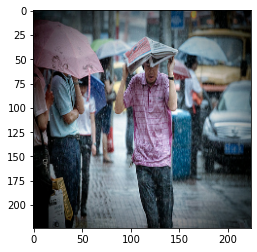

In [76]:
image = load_image(MAIN_PATH + IMAGE_DIR + "/" + "_33142977.jpg")
indexes, prob, length = model.simple_gen_beam(image)
indexes = indexes[0]
string = []
sep = " "
for i in range(1, len(indexes)-1):
  string.append(index_to_word(indexes[i]).numpy().decode('utf-8'))

print(sep.join(string))

plt.figure()
plt.imshow(image/255)
plt.show()

Παρακάτω, ορίζουμε τη συνάρτηση `cal_corpus_bleu` που με είσοδο την τιμή θερμοκρασίας και ένα συγκεκριμένο μοντέλο, υπολογίζει το BLEU score πάνω σε ένα υποσύνολο του test set (παράμετρος length) από τα captions που παράγει το μοντέλο. 

In [77]:
import math
def cal_corpus_bleu(length, model, temp):

   hyp_list = []
   ref_list = []

   test_list = test_captions[:length]

   for img_path, capdict in test_list:
      image = load_image(img_path)
      hypothesis = model.simple_gen(image,temp)
      hyp_tokens = cap_tokenizer(hypothesis)
      
      hyp_list.append(hyp_tokens)

      tokens_list = []
      for cap in capdict:
         tokens_list.append(cap_tokenizer(cap))
    

      ref_list.append(tokens_list)

   bleu_corpus = corpus_bleu(ref_list,hyp_list,weights=(0.4, 0.3, 0.2, 0.1),smoothing_function=SmoothingFunction().method1)

   print(f'BLEU score (T = {temp}) = {round(bleu_corpus, 3)}')


Τέλος, υλοποιούμε την συνάρτηση `cal_corpus_bleu_beam`. Τροποποιούμε κατάλληλα την `cal_corpus_bleu` που παρατίθεται παραπάνω:
* Χρησιμοποιεί την `simple_gen_beam` για να υπολογίσει το ΒΕΑΜ BLEU Score στο test set
* Ορίζει ως παράμετρο τα `beams`, τα οποία αναφέρονται στο [tutorial](https://towardsdatascience.com/foundations-of-nlp-explained-visually-beam-search-how-it-works-1586b9849a24) ως beam width. Αναφέρονται στο πλήθος από μονοπάτια/captions θα ακολουθεί/παράγει παράλληλα. Αναλυτικότερα, σε κάθε βήμα της μεθόδου κρατάμε τα beams καλύτερα captions μέχρι εκείνη τη στιγμή, όπου ως καλύτερα θεωρούνται εκείνα που έχουν την μεγαλύτερη συνολική πιθανότητα.

In [78]:
def cal_corpus_bleu_beam(length, model, beams):
  
  hyp_list = []
  ref_list = []

  test_list = test_captions[:length]
  sep = " "

  counter = 1
  for img_path, capdict in test_list:
    image = load_image(img_path)
    hypothesis, prob, length = model.simple_gen_beam(image, beams)
    hypothesis = hypothesis[0]
    hypothesis_ = []
    for i in range(1, len(hypothesis)-1):
      hypothesis_.append(index_to_word(hypothesis[i]).numpy().decode('utf-8'))

    hypothesis__ = sep.join(hypothesis_)
    hyp_tokens = cap_tokenizer(hypothesis__)
    hyp_list.append(hyp_tokens)

    tokens_list = []
    for cap in capdict:
        tokens_list.append(cap_tokenizer(cap))


    ref_list.append(tokens_list)
    counter += 1

  bleu_corpus = corpus_bleu(ref_list,hyp_list,weights=(0.4, 0.3, 0.2, 0.1),smoothing_function=SmoothingFunction().method1)

  print(f'BEAM BLEU score = {round(bleu_corpus,3)}')

---

Tρέχουμε την συνάρτηση `cal_corpus_bleu` με `temperature=0` στις πρώτες 1001 εικόνες του dataset για το καλύτερο μας μοντέλο.

In [79]:
cal_corpus_bleu(1001, model, 0)

BLEU score (T = 0) = 0.251


Tρέχουμε την συνάρτηση `cal_corpus_bleu_beam` με `beams=3` στις πρώτες 1001 εικόνες του dataset για το καλύτερο μας μοντέλο.

In [103]:
cal_corpus_bleu_beam(1001, model, 3)

BEAM BLEU score = 0.263


Tρέχουμε την συνάρτηση `cal_corpus_bleu_beam` με `beams=5` στις πρώτες 1001 εικόνες του dataset για το καλύτερο μας μοντέλο.

In [80]:
cal_corpus_bleu_beam(1001, model, 5)

BEAM BLEU score = 0.264


### Αποτελέσματα Δοκιμών
---

Κάναμε αρκετες δοκιμές με τις εξής υπερπαραμέτρους:

*   `units`, trainable (50, 150, 256, 300, 350, 450, 550) ή pretrained (300) 
*   `dropout_rate`
*   `num_layers`
*   `num_heads`
* CNN : `Mobilenet` ή `EfficientNetV2S`

Σημείωση: Υπολογίζουμε το BLEU score μόνο εάν το Val_loss είναι σχετικά χαμηλό καθώς διαφορετικά παρατηρήσαμε ότι δεν περιμένουμε καλά αποτέλεσμα όσον αφορά τα Bleu Scores.

Τα αποτελέσματα των δοκιμών μας συνοψίζονται στους παρακάτω πίνακες.


* **Mobilenet με trainable word embeddings :**

| Embeddings | vocab_size |	num layers| num heads | dropout	| val_loss | BLEU Score (T = 0) | Beam Blue Score|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|50	|5000	| 2	|2 |  0.1| 3.03 | 0.23	|  0.24|
|150|5000 |	2|	3| 0.2|	3.04 | 0.21 |  0.23|
|250|	5000|	2|	4| 0.2|	3.02 | 0.22|	0.236|
|256|	5000|	2|	7| 0.2|	3.01 | 0.22|	0.243|
|256|	5000|	4|	7| 0.4|	3.01 | 0.22|	0.245|
|300 | 3500 | 3 | 3 | 0.3 | 3.041 | 0.22 | 0.23  
|300 | 3500 | 3 | 5 | 0.3 | 3.07 | 0.20 | 0.21
300 | 3500 | 3 | 5 | 0.3 | 3.07 | 0.20 | 0.21 
300 | 3500 | 3 | 5 | 0.2 | 3.22 | - | - 
256 |3500|3 | 5 | 0.3 | 3.15 | - | - 
300 |3500|3 | 3 | 0.4 | 3.14 | - | - 
300 |3500|3 | 3 | 0.3 | 3.04 | 0.216 | 0.23  
300 |3500|3 | 3 | 0.2 | 3.09 | 0.19 | 0.21 
300 |3500|3 | 5 | 0.3 | 3.07 | 0.197 | 0.21 
256 |5000 | 3 | 5 | 0.3 | 3.19 | - | - 
300 |6500|3 | 5 | 0.3 | 3.21 | - | - 
|350|	5000   |	3|	3| 0.3| 3.01 |	0.220|	0.245|
| 450| 5000  |	3|	4| 0.4| 2.98 |	0.232 | 0.252 🔥|
|550|	5000   |	2|	3| 0.2| 3.03 |	0.21|	0.246|
|550|	5000   |	4|	6| 0.5| 2.97 |	0.23|	0.250 🔥|

* **EfficientNet με trainable word embeddings :**

| Embeddings | vocab_size |	 num layers| num heads	|dropout rate| val_loss | BLEU Score (T = 0) | Beam Blue Score|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
256 | 3500 | 2 | 2 | 0.5 | 2.969 | 0.219 | 0.239
256 | 3500 | 2 | 2 | 0.3 | 2.972 | 0.218 | 0.237
256 | 3500 | 2 | 3 | 0.5 | 2.982 | 0.225 | 0.249
256 | 3500 | 2 | 4 | 0.5 | 3.073 | 0.234 | 0.241
256 | 3500 | 2 | 4 | 0.3 | 3.025 | 0.22 | 0.236
256 | 3500 | 3 | 3 | 0.3 | 3.024 | 0.214 | 0.233
256 | 3500 | 4 | 3 | 0.5 | 3.066 | 0.213 | 0.227
300 | 3500 | 4 | 4 | 0.5 | 3.02 | 0.207 | 0.224
300 | 5000 | 2 | 2 | 0.5 | 3.11 | 0.21 | 0.233
300 | 5000 | 2 | 2 | 0.3 | 3.11 | 0.204 | 0.227
300 | 5000 | 2 | 3 | 0.5 | 3.25 | 0.162 | 0.215
300 | 5000 | 2 | 4 | 0.5 | 3.17 | 0.2 | 0.23
300 | 5000 | 2 | 5 | 0.5 | 3.16 | 0.202 | 0.233
300 | 5000 | 2 | 6 | 0.5 | 3.25 | 0.17 | 0.19
300 | 5000 | 2 | 6 | 0.4 | 3.151 | 0.21 | 0.229
300 | 5000 | 2 | 6 | 0.3 | 3.067 | 0.223 | 0.231
300 | 5000 | 3 | 2 | 0.5 | 3.25 | - | -
300 | 5000 | 3 | 3 | 0.5 | 3.1 | 0.195 | 0.219
300 | 5000 | 3 | 3 | 0.3 | 3.22 | - | -
300 | 5000 | 3 | 4 | 0.5 | 3.106 | 0.223 | 0.235
300 | 5000 | 3 | 5 | 0.5 | 3.147 | 0.225 | 0.241  🔥
300 | 5000 | 3 | 6 | 0.5 | 3.295 | - | -
300 | 5000 | 4 | 3 | 0.5 | 3.104 | 0.219 | -
300 | 5000 | 4 | 3 | 0.3 | 2.967 | 0.242 | 0.247 🔥
256 | 5000 | 2 | 3 | 0.5 | 3.167 | 0.215 | 0.238
256 | 5000 | 3 | 2 | 0.3 | 3.172 | - | -
256 | 5000 | 3 | 3 | 0.5 | 3.173 | - | -
256 | 5000 | 3 | 4 | 0.5 | 3.2   | - | -
256 | 5000 | 3 | 4 | 0.3 | 3.022 | 0.228 | 0.244 🔥
256 | 5000 | 3 | 4 | 0.2 | 2.996 | 0.217 | 0.238
300 |6500| 2 | 2 | 0.5 | 3.19 | - | -
300 |6500| 2 | 2 | 0.3 | 3.16 | - | -
256 |6500| 2 | 3 | 0.3 | 3.14 | - | -
300 |6500| 2 | 4 | 0.5 | 3.17 | - | -
256 |6500| 2 | 5 | 0.5 | 3.14 | - | -
300 |6500| 3 | 3 | 0.7 | 3.16 | - | -
256 |6500| 3 | 4 | 0.3 | 3.14 | - | -
300 |6500| 4 | 5 | 0.3 | 3.10 | 0.21 | 0.23

* **Mobilenet with pretrained embeddings :**


|vocabulary size| Num Heads | Num Layers | Dropout Rate |  Val_loss | BLEU Score (T = 0)| Beame BLEU Score
|:-:| :---------:|:----------:|:------------:|:----:|:----:|:----:|
|3500|    2       |  3         |   0.5        | 3.30|- | -
|3500|    7       |  4         |   0.5        |3.07|0.21|0.22|
|3500|    7       |  5         |   0.4        |2.96|0.2|0.22|
|3500|    3       |  4         |   0.4        |3.03|0.21|0.23|
|3500|    5       |  4         |   0.4        |3.03|0.21|0.21|
|3500|    7       |  4         |   0.4        |3.02|0.22|0.24|
|3500|    5       |  3         |   0.3        |3.14|- | -
|3500|    7       |  3         |   0.3        |2.31|0.22|0.23|
|3500|    7       |  5         |   0.2        |3.05|0.21|0.23|
|3500|    3       |  4         |   0.2        |3.01|0.23|0.24 🔥|
|3500|    5       |  4         |   0.2        |3.05|0.21|0.23|
|3500|    7       |  4         |   0.2        |3.05|0.22|0.23|
|3500|    5       |  4         |   0.1        |3.19|0.21|0.23|
|3500|    7       |  4         |   0.1        |3.07|0.2|- 
|5000|    4       |  2         |   0.3        |3.12|0.2|0.21|
|5000|    5       |  2         |   0.3        |3.1|0.21|0.23|
|5000|    7       |  2         |   0.3        |3.16|- | -
|5000|    3       |  3         |   0.3        |3.13|0.21|0.23|
|5000|    4       |  3         |   0.3        |3.19|- | -
|5000|    5       |  3         |   0.3        |3.05|0.22|0.23|
|5000|    6       |  3         |   0.3        |3.33|- | -
|5000|    5       |  4         |   0.3        |3.06|0.22|0.23|
|5000|    6       |  4         |   0.3        |3.20|- | -
|5000|    7       |  4         |   0.3        |3.05|0.22|0.23|
|5000|    3       |  5         |   0.3        |3.06|0.22|0.23|
|5000|    5       |  5         |   0.3        |3.14|- | -
|5000|    7       |  5         |   0.3        |3.19|- | -
|5000|    5       |  3         |   0.2        |3.4|- | -
|5000|    7       |  3         |   0.2        |3.23|- | -
|5000|    7       |  5         |   0.2        |3.06|0.21|0.23|
|5000|    7       |  7         |   0.2        |2.94|0.22|0.23|
|5000|    5       |  4         |   0.2        |3.18|- | -
|5000|    5       |  4         |   0.1        |3.13|- | -
|5000|    5       |  3         |   0.1        |3.25|- | -
|5000|    5       |  5         |   0.1        |3.32|- | -
|5000|    7       |  5         |   0.1        |3.13|- | -
|5000|    5       |  4         |   0.4        |3.07|0.22|0.23|
|5000|    7       |  4         |   0.4        |3.2|- | -
|6500|    3       |  2         |   0.4        |3.26|0.21|0.23|
|6500|    4       |  2         |   0.4        |3.2|0.19|0.22|
|6500|    5       |  2         |   0.4        |3.1|0.2|0.23|
|6500|    3       |  3         |   0.3        |3.05|0.2|0.22|
|6500|    3       |  3         |   0.4        |3.06|0.2|0.22|
|6500|    7       |  4         |   0.3        |3.01|0.18|- 
|6500|    3       |  4         |   0.3        |3.03|0.21|- 
|6500|    5       |  4         |   0.3        |3.16|- | -
|6500|    7       |  4         |   0.3        |3.01|0.225|0.231|

* **EfficientNet with Embeddings :**

|vocabulary |num_heads | num_layers | dropout_rate |  val_loss | BLEU | BLEU with beam
|:---------:|:----------:|:------------:|:----:|:----:|:----:|:-----:|
3500 | 2 | 2 | 0.5 | 3.25 | 0.19 | - |
6500 | 2 | 2 | 0.5 | 3.37 | - | - |
5000 | 2 | 2 | 0.5 | 3.20 | 0.20 | 0.22 |
5000 | 2 | 2 | 0.3 | 3.05 | 0.22 | 0.21 | 
5000 | 3 | 2 | 0.3 | 3.10 | 0.19 | - |
5000 | 3 | 3 | 0.3 | 3.05 | 0.21 | 0.22 |
**5000** | **5** | **3** | **0.3** | 2.85 | 0.251 | 🔥**0.256** 🔥|
5000 | 4 | 5 | 0.2 | 3.12 | - | - |
5000 | 4 | 5 | 0.3 | 3.23| - | - |
5000 | 7 | 2 | 0.3 | 3.10 | - | - |

---
Με βάση λοιπόν τα παραπάνω αποτελέσματα καταλήξαμε στις εξής τιμές των hyperparameters:

*   **Embeddings = `glove-wiki-gigaword-300`**
*   **Encoder = `EfficientNetV2S`**
*   **`dropout_rate` = 0.3**
*   **`num_layers` = 3**
*   **`num_heads` = 5**


Το μοντέλο που εκπαιδεύτηκε με τις παραπάνω υπερπαραμέτρους πετυχαίνει :

```
BLEU score (T = 0) = 0.251 (1001 πρώτες εικόνες του dataset)
BEAM BLEU score = 0.264 (1001 πρώτες εικόνες του dataset και beams = 5)
```
(μεγάλη αύξηση συγκριτικά με το αρχικό έτοιμο μοντέλο του tensorflow που είχε Blue score ~ 0.14 ! και ίσως θα μπορούσαμε να πετύχουμε ακόμα καλύτερες επιδόσεις με τις υπερπαραμέτρους αυτές αν εκπαιδεύαμε το μοντέλο για περισσότερες εποχές - δεδομένο ότι η εφαρμογή Early Stopping θα βοηθήσει στην αποτροπή φαινομένων overfittng).

---

Σε κάθε περίπτωση σημαντικό ρόλο παίζει η αρχικοποίηση των βαρών του δικτύπου και επομένως μπορεί να έχουμε διαφορετικές τιμές ανά τρέξιμο και ως καλύτερο μοντέλο να προκύψει διαφοροποιημένες τιμές υπερπαραμέτρων. Επίσης, έχουμε θεωρήσει **beams = 3** ώστε να είναι πιο γρήγορες οι δοκιμές και να μπορούμε να κάνουμε περισσότερες. Παρατηρήσαμε μετά από κάποιες αρχικές δοκιμές ότι το beams = 5 επιτυγχάνει ελαφρώς μεγαλύτερο score της τάξης του τρίτου δεκαδικού ψηφίου και ότι παίρνει περίπου 3 ώρες για τους υπολογιμσούς την στιγμή που με beams = 3 χρειάζεται μόνο μία ώρα για τον υπολογισμό του beam score. Δεν "αξίζει" λοιπόν ειδικά δεδομένων των περιορισμών στην πρόσβαση σε GPU.

Ενδεικτικά: 

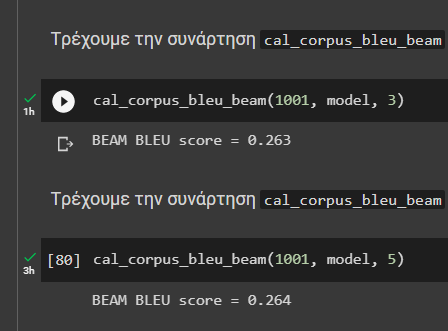


Όσον αφορά τα embeddings (`num_units`), αυξάνουμε τη διαστατικότητα του με την αύξηση των υπόλοιπων υπερπαραμέτρων. Η λογική που ακολουθήσαμε γενικά ήταν η σταδιακή αύξηση των layers (`num_layers`) του `Decoder` και των heads (`num_heads`) ανά `Attention Layer` και του `dropout_rate` να γίνεται παράλληλα. Έτσι θέλουμε να αποτρέψουμε εμφάνιση φαινομένων overfitting καθώς όσο αυξάνουμε `num_heads` και `num_layers` αυξάνονται οι παράμετροι του Transformer και άρα έχουμε μεγαλύτερη πιθανότητα για overfitting, οπότε θα βοηθήσει επιλογή μεγαλύτερης τιμής `dropout_rate`.

Το dropout rate = 0.5 που είναι το default παρατηρήσαμε ότι είναι σχετικά μεγάλο και καλύτερες τιμές γενικά δίνουν οι τιμές 0.3 και 0.4. Γενικά, παρατηρήσαμε ότι είναι μεγάλη η επίδραση του dropout rate και για αυτό είναι καθοριστική για την επίδοση η κατάλληλη επιλογή του. 
Ενδεικτικά, εντοπίστηκε παράδειγμα όπου διατηρώντας τις υπόλοιπες υπαραπαμέτρους σταθερές και τροποποιώντας μόνο το dropout rate από 0.1 σε 0.3 αυξάνουμε κατά ~ 0.15 το Beam Blue Score που για τα δεδομένα του προβλήματός μας είναι αρκετά σημαντική αύξηση. 

Παρατηρούμε ότι αυξάνοντας τα `num_heads` και τα `num_layers` (αρχικές τιμές 2 και για τις δύο υπερπαραμέτρους) το Beam Search BLEU score αυξάνεται σημαντικά φτάνοντας ~0.25. Αυξάνοντας τα `num_heads` εξάγουμε περισσότερα features - patterns από το input caption. Aυξάνοντας τα `num_layers`  η δομή του Transformer γίνεται πιο περίπλοκη που σημαίνει ότι μπορεί και να μάθει πιο περίπλοκα patterns από την είσοδο. Επομένως, η παρατήρησή μας είναι λογική. Βέβαια, αυτό μέχρι ενός σημείου καθώς παρατηρούμε ότι αύξηση των `num_heads` πάνω από 5 και `num_layers` πάνω από 4-5 δεν έχει νόημα καθώς δεν καταφέρνει να αυξήσει το Beam Search BLEU score πάνω από 0.25 ή ακόμα και μειώνεται. Ίσως με περισσότερες εποχές (και ίσως μεγαλύτερο patience στο Early Stopping) κατά το training να μπορούσε ο πιο περίπλοκος τώρα Transformer να εκπαιδευτεί καλύτερα χωρίς αυτό να οδηγήσει απαραίτητα σε καλύτερα αποτελέσματα (λόγω εμφάνισης φαινομένων overfitting).

Τέλος όσον αφορά τη διαστατικότητα των Embeddings, πολύ μικρές τιμές δεν οδηγούν σε καλά αποτελέσματα (λογικό, πολύ διαφορετικές λέξεις δεν απέχουν πολύ διανυσματικά σε σχέση με μεγαλύτερες διαστάσεις) και για αυτό επιλέγουμε τιμές μεταξύ 300-550.






Cherry Picking
---
Παραδείγματα εικόνων με ικανοποιητικά captions. 

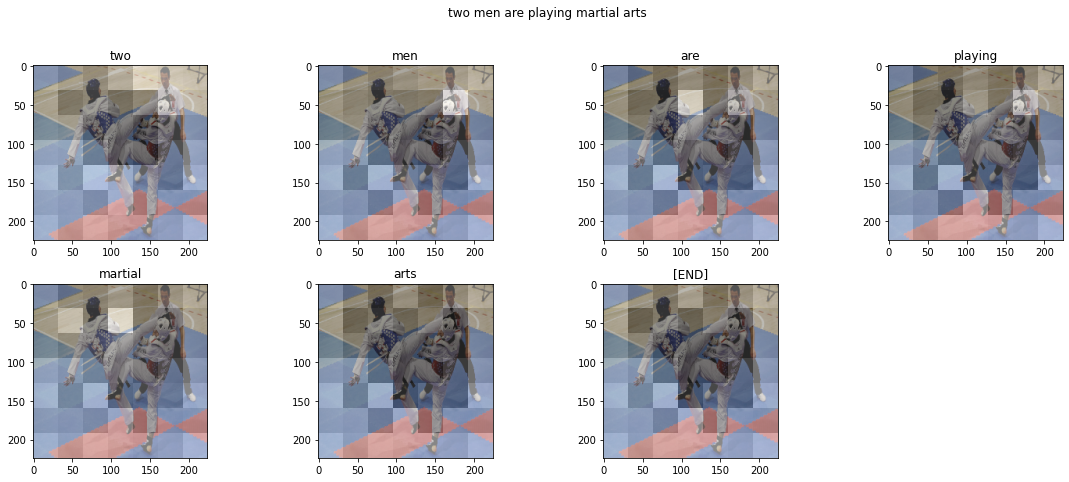

In [93]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_399500.jpg')
run_and_show_attention(model, image)
# καλό δεδομένου ότι ο 3ος απλά είναι διαιτητής

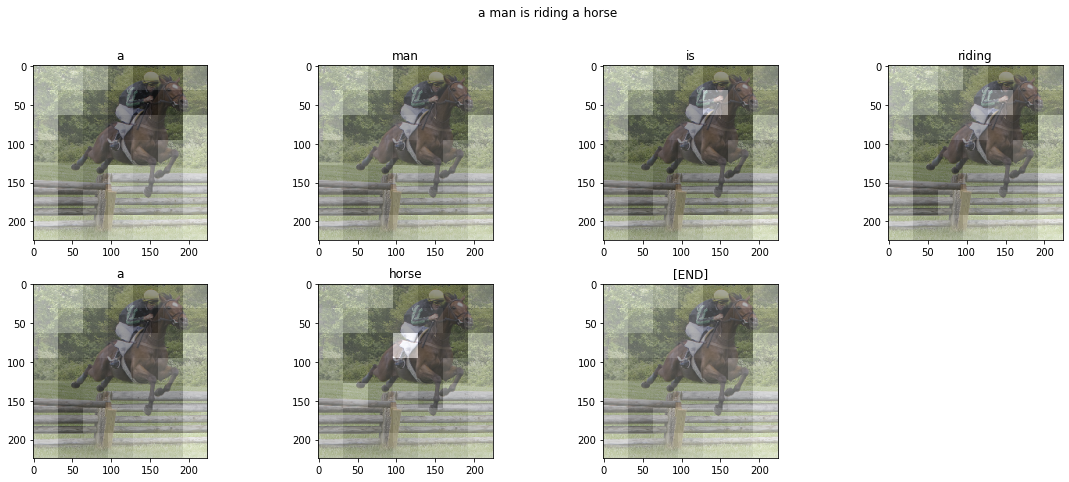

In [98]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_904240.jpg')
run_and_show_attention(model, image)

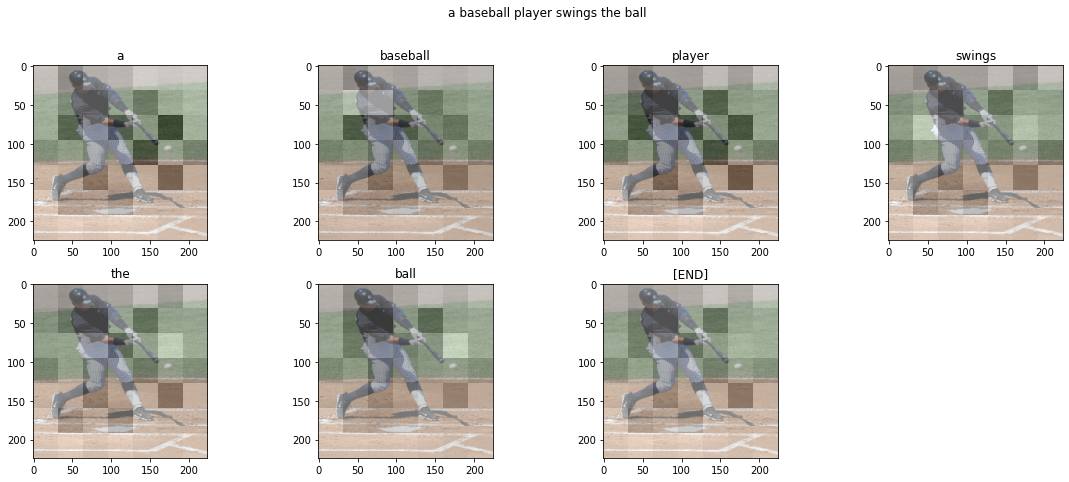

In [101]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_1061948.jpg')
run_and_show_attention(model, image)

# αναγνωρίζει το συγκεκριμένο άθλημα !!

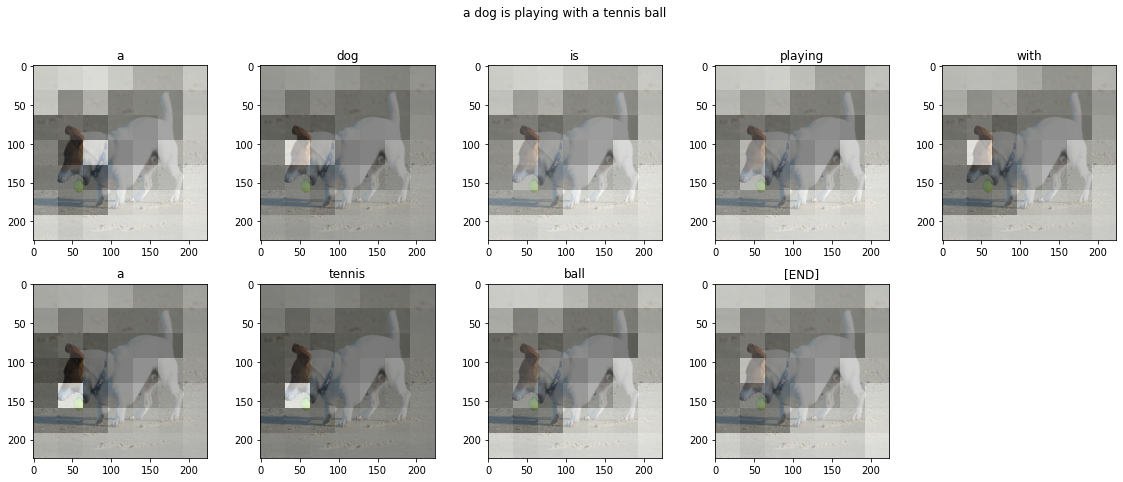

In [102]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_1303720.jpg')
run_and_show_attention(model, image)

# αναγνωρίζει και ότι η μπαλίτσα είναι tennis !! 

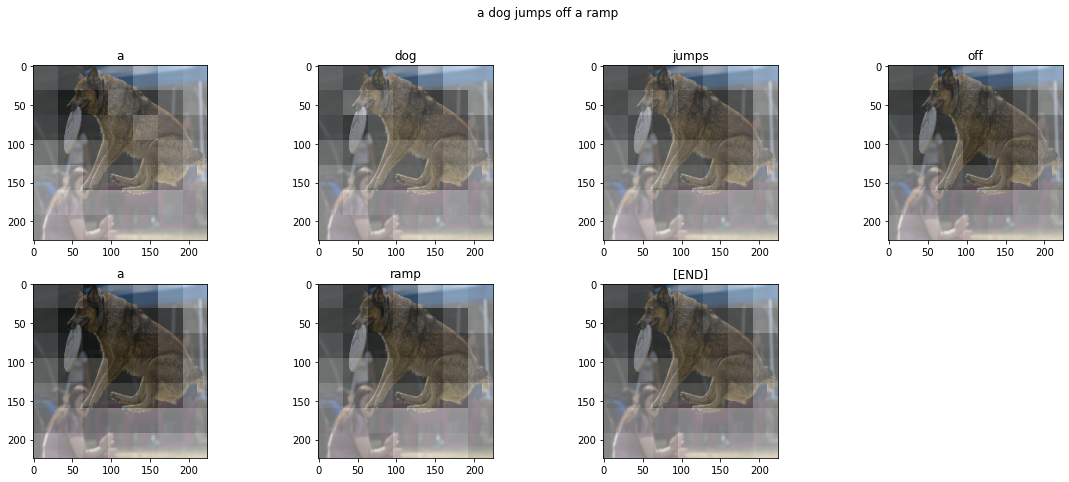

In [82]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_172577405.jpg')
run_and_show_attention(model, image)

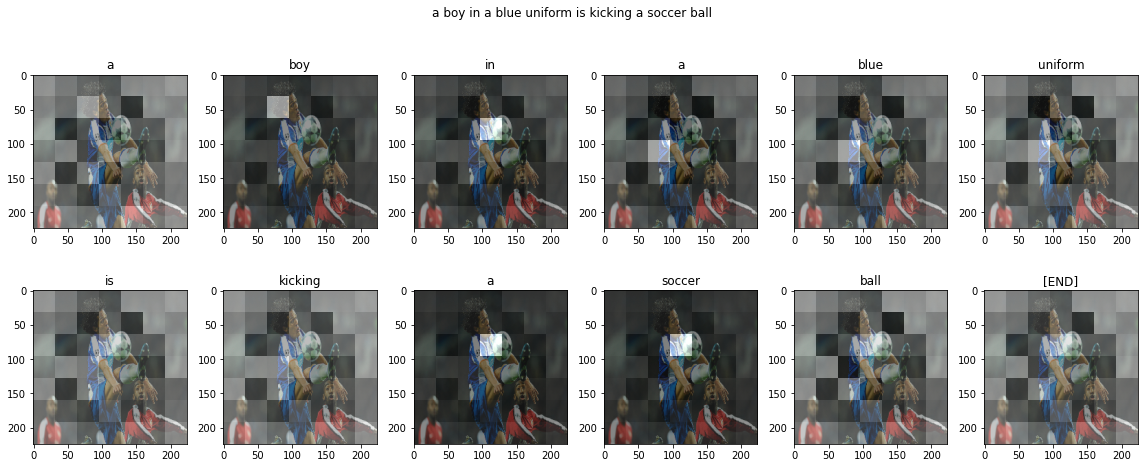

In [88]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_1127412.jpg')
run_and_show_attention(model, image)

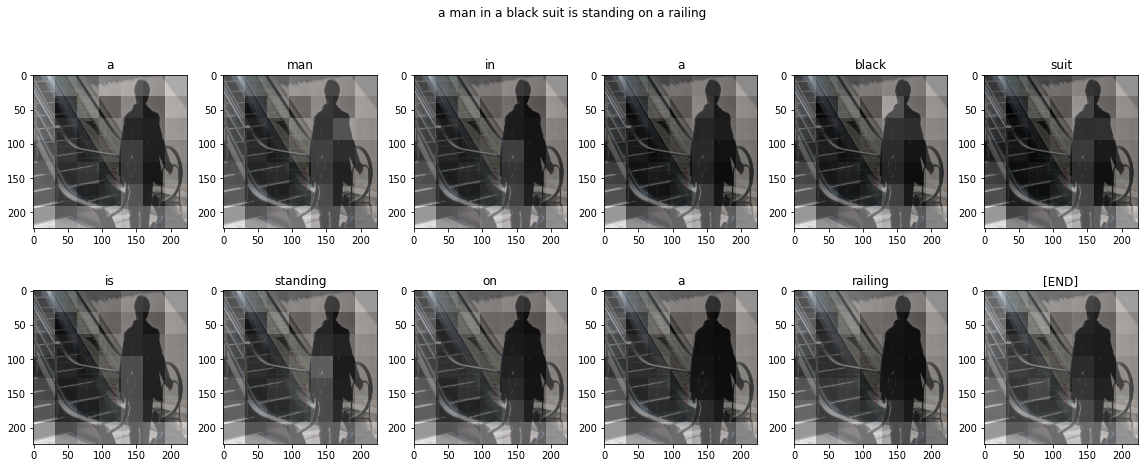

In [85]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_48535595.jpg')
run_and_show_attention(model, image)

Nit Picking
---
Παραδείγματα εικόνων με μη-ικανοποιητικά captions (δεν στέκουν καν νοηματικά ως προτάσεις).

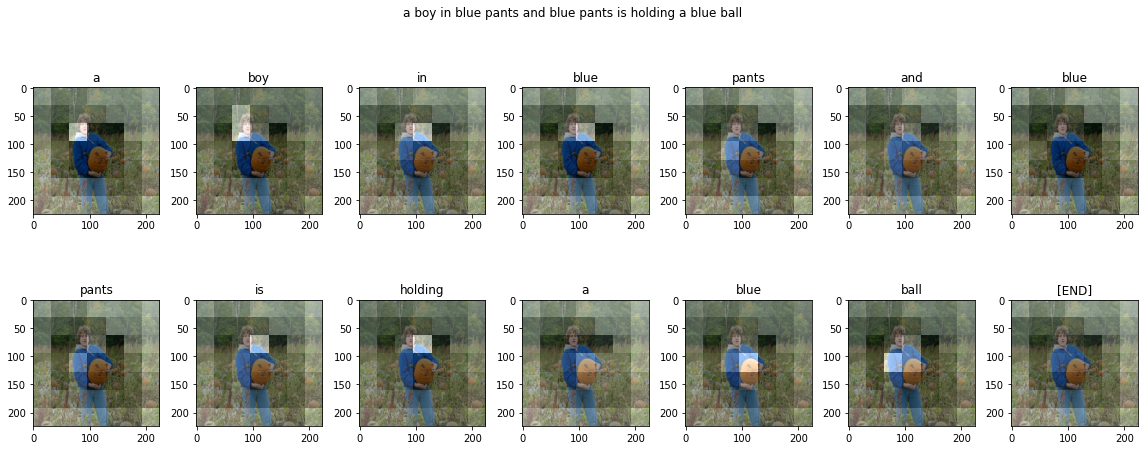

In [95]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_451080.jpg')
run_and_show_attention(model, image)

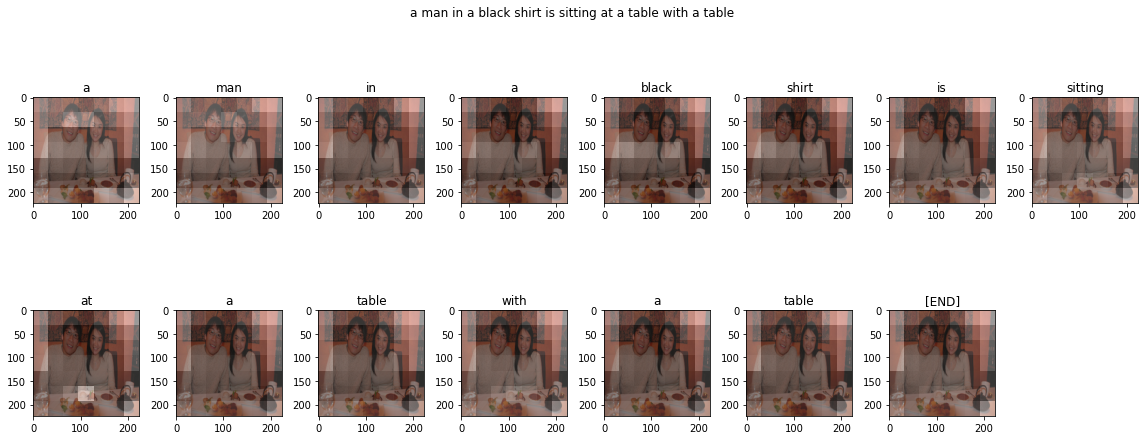

In [100]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_915294.jpg')
run_and_show_attention(model, image)

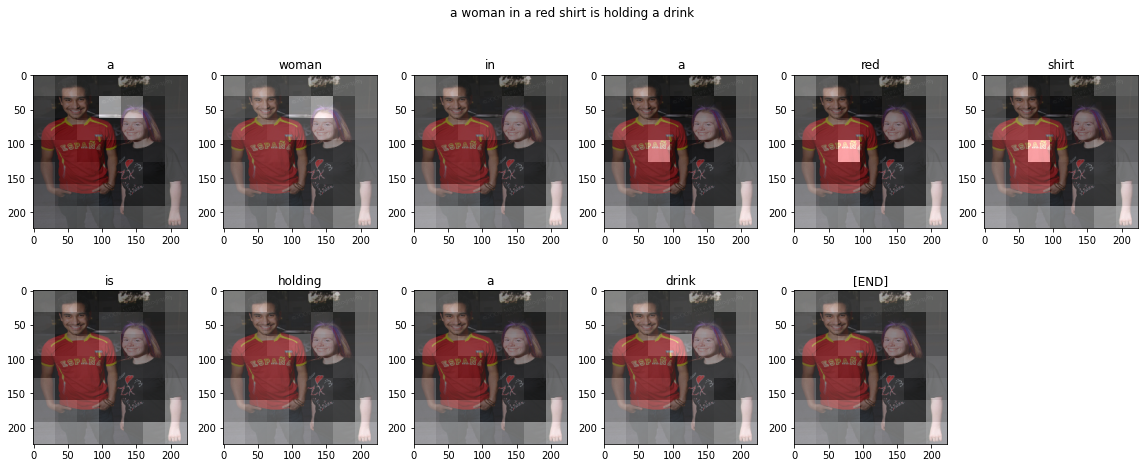

In [92]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_363664.jpg')
run_and_show_attention(model, image)


Σημείωση: Παραθέτουμε και κάποια παραδείγματα στα οποία το σύστημα έχει μέτρια επίδοση. Στο 1ο δεν αναγνωρίζει ότι πρόκειται για soccer (ενώ σε άλλα τρεξίματα το αναγνώριζε), στο 2ο η κοπέλα είναι όρθια και μάλλον σε αεροπλάνο και στο 3ο δεν φοράει φόρεμα. 

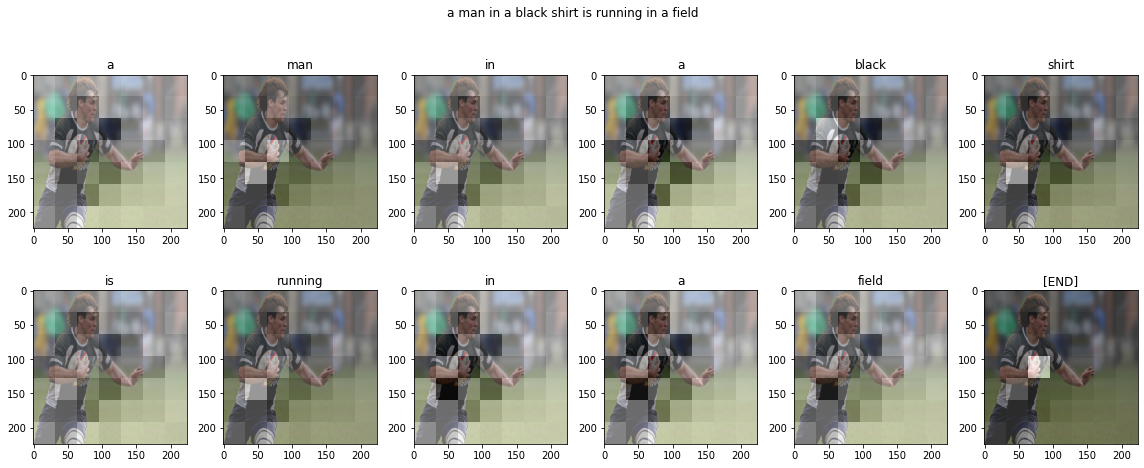

In [81]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_185259864.jpg')
run_and_show_attention(model, image)

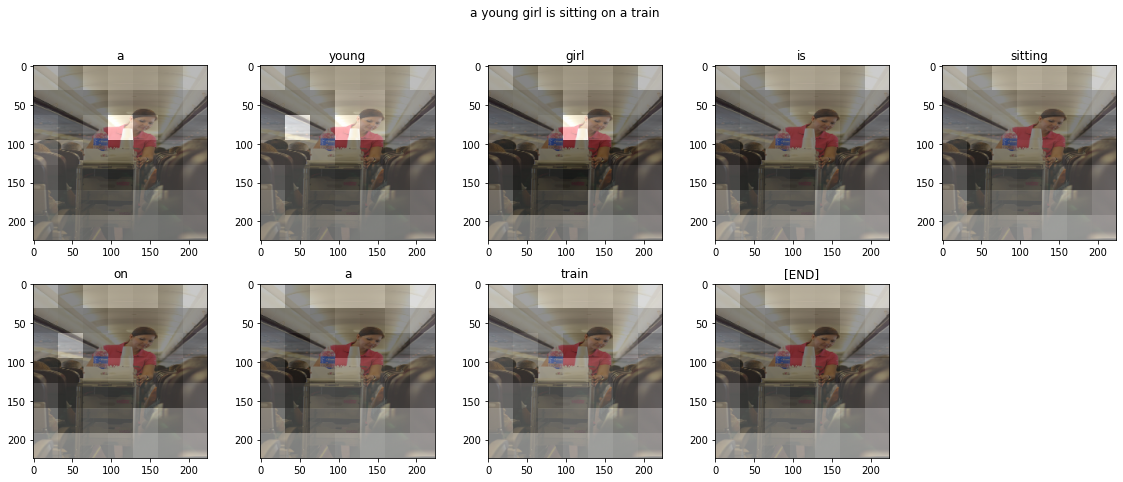

In [86]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_39507710.jpg')
run_and_show_attention(model, image)

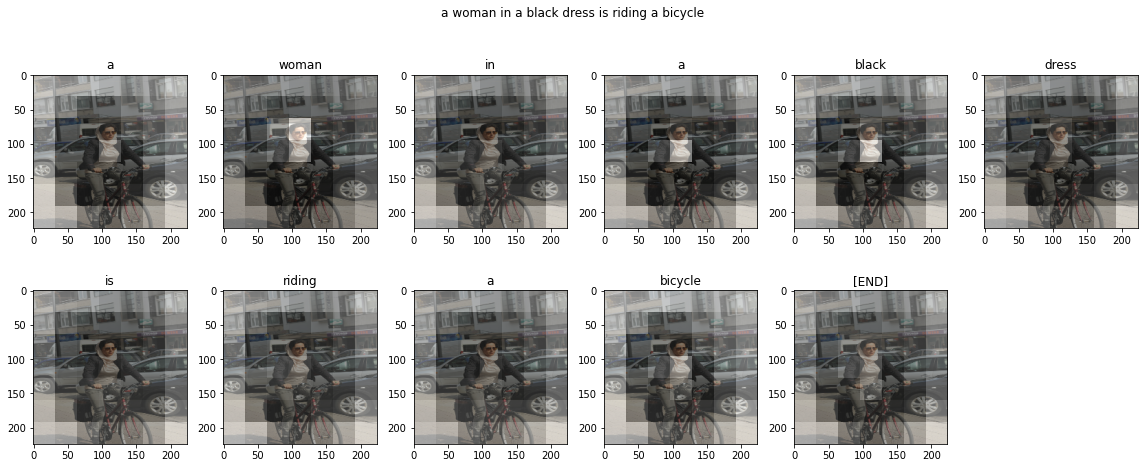

In [87]:
image = load_image(f'{MAIN_PATH}/{IMAGE_DIR}/_41982448.jpg')
run_and_show_attention(model, image)